---
# Código elaborado por Morales Ramírez Ángel Franciso [LinkedIn](https://www.linkedin.com/in/francisco-morales-actuario/)
---

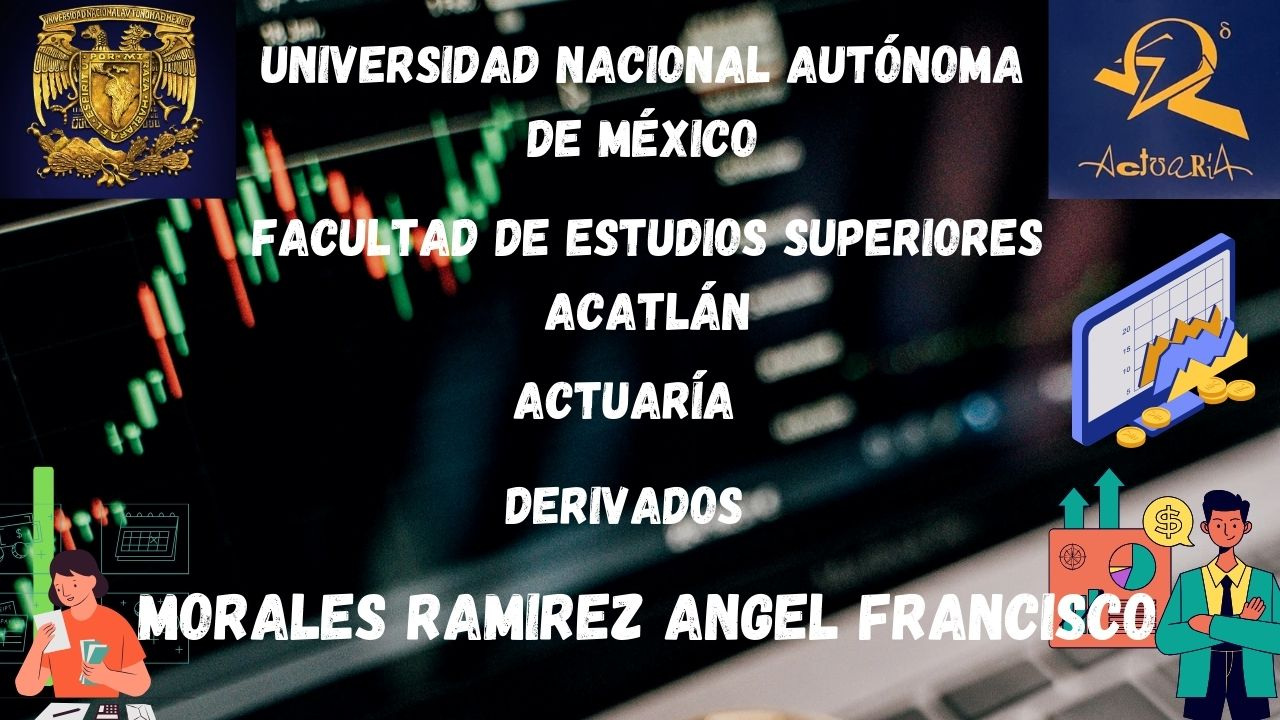

---
# Instrucciones 👨‍🏫
---



*   Portafolio de Inversion de n activos con grafico para las opciones de compra y venta por acción



---
# Instalación e importación de librerías🐍
---

In [1]:
# Instalación de librerías
! pip install yfinance
# Cálculos matemáticos
! pip install numpy
# Manipular Dataframes
! pip install pandas
# Análisis de datos en series temporales financieras
! pip install pandas_ta
# Gráficos
! pip install plotly

In [2]:
#Para evitar problemas con la importación de pandas_ta en diferentes entornos (Visual Code , Google Colab, etc)
!sed -i 's/from numpy import NaN as npNaN/from numpy import nan as npNaN/' /usr/local/lib/python3.11/dist-packages/pandas_ta/momentum/squeeze_pro.py

In [3]:
#Librerías a utilizar
#Usar información de yahoo finance
import yfinance as yf
#Manipular Dataframes
import pandas as pd
#Cálculos matemáticos
import numpy as np
#Gráficos
import plotly.graph_objects as go
#Análisis de datos en series temporales financieras
import pandas_ta as ta


---
# Componentes del Portafolio 💼
---

In [4]:
#C--> Comisión
#Comisión de 0.25% por compra o venta de casa de bolsa
Comision=0.0025

# Se pedirá número acciones en el portafolio
#na --> Número de acciones
# int -->Convierte en valor entero
# input --> El usuario ingresa el dato
na = int(input("¿Cuántas acciones hay en tu portafolio? 📈: "))

# Lista para guardar los nombres de las acciones
#ts-->Tickers
ts = []

# Se pedirá el nombre de cada acción
# t --> Ticker de la acción
# input --> El usuario ingresa el dato
# for -->Ciclo for para introducir el ticker de cada acción de acuerdo al range (na)
# ts.append(t) --> se agrega el ticker a la lista
# i + 1-->Porque Python empieza sus litas en 0
for i in range(na):
    t = input(f"Nombre del ticker #{i + 1} 🏦: ")
    ts.append(t)

# Se mostrará el portafolio al usuario
#\n -->Salto de linea
print("\nTu portafolio está compuesto por los siguientes tickers 💼:")
for t in ts:
    print(f"📌 {t}")

¿Cuántas acciones hay en tu portafolio? 📈: 4
Nombre del ticker #1 🏦: LACOMERUBC.MX
Nombre del ticker #2 🏦: WALMEX.MX
Nombre del ticker #3 🏦: Q.MX
Nombre del ticker #4 🏦: CUERVO.MX

Tu portafolio está compuesto por los siguientes tickers 💼:
📌 LACOMERUBC.MX
📌 WALMEX.MX
📌 Q.MX
📌 CUERVO.MX


---
#Funciones 🧠
---

In [5]:
#Definición de funciones a utilizar

#Función de extracción de información de Yahoo Finance de 1 mes cada 60 minutos
def get_data(symbol: str):
    data=yf.download(tickers=symbol, period='44d', interval='60m')
    data.reset_index(inplace=True)
    return data

# Función para calcular el Promedio Móvil
def calculate_sma(data, length: int):
    return ta.sma(data['Close'], length)

# Función para determinar la tendencia - equilibrada
def determine_trend(data):
    if data['SMA_10']>data['SMA_20']>data['SMA_30']:
        return 2 # Tendencia de Alza
    elif data['SMA_10']<data['SMA_20']<data['SMA_30']:
        return 1 # Tendencia de Baja
    else:
        return 0 # Sin tendencia definida


# Función para calcular RSI (Relative Strength Index)
# Se utliza en los mercados como un indicar de Sobrecompra o sobreventa
# Valores por arriba de 70% indican que estan en un territorio de sobrecompra
# Valores por abajo de 30% indican que estan en un territorio de sobreventa
def rsi(DF, n=20):
    df=DF.copy()
    df['dif'] = df['Close']-df['Close'].shift(1)
    df['gain'] = np.where(df['dif']>=0, df['dif'], 0)
    df['loss'] = np.where(df['dif']<0, abs(df['dif']), 0)
    average_gain = []
    average_loss = []
    gain=df['gain'].tolist()
    loss=df['loss'].tolist()
    for i in range(len(df)):
      if i < n:
        average_gain.append(np.nan)
        average_loss.append(np.nan)
      elif i == n:
        average_gain.append(df['gain'].rolling(n).mean()[n])
        average_loss.append(df['loss'].rolling(n).mean()[n])
      elif i > n:
        average_gain.append(((n-1)*average_gain[i-1]+gain[i])/n)
        average_loss.append(((n-1)*average_loss[i-1]+loss[i])/n)
    df['average_gain'] = np.array(average_gain)
    df['average_loss'] = np.array(average_loss)
    df['RS'] = df['average_gain']/df['average_loss']
    df['RSI'] = 100-(100/(1+df['RS']))
    return df['RSI']


---
#Información de Yahoo Finance y tendencias💰
---

In [6]:
#Dataframe tickers
#Este dataframe guarda las señales para todos los tickers
def datos(t):
#Se obtene la información de Yahoo Finance
  data=get_data(t)
#set_axis-->Renombran las columnas
#axis=1 -->Columnas
  data=data.set_axis(['Datetime','Close','High','Low','Open','Volume'], axis=1)
#Se calculan los promedios móviles para los últimos 10, 20 y 30 días
#Se agregan al data frame
  data['SMA_10']=calculate_sma(data,10)
  data['SMA_20']=calculate_sma(data,20)
  data['SMA_30']=calculate_sma(data,30)
# Determinar la tendencia en una nueva columna del dataframe
  data['Tendencia']=data.apply(determine_trend,axis=1)
# Se calcula el RSI y se integra al Dataframe
  RSI_data=rsi(data,n=20)
  data=pd.concat([data,RSI_data], axis=1)
# Determinar en que periodos hubo tendencia de alza y de baja - se guarda en un nuevo dataframe y lo reindexamos
  df=data[data['Tendencia']!=0]
  df=df.reset_index()
# Determinar la señal de Compra o Venta y definir el precio de dicha señal
  df.loc[0,'Señal']=df.loc[0,'Tendencia']
  for i in range(1,len(df)):
      if df.loc[i,'Tendencia']==df.loc[i-1,'Tendencia']:
          df.loc[i,'Señal']=0
      else:
          df.loc[i,'Señal']=df.loc[i,'Tendencia']
#Corregir la primera fila, en caso de que la primera señal, sea una señal de venta
  if df.loc[0,'Señal']==1:
      df.loc[0,'Señal']=0
  else:
      df.loc[0,'Señal']=2
#Quitar todos los ceros del dataframe con la columna 'Señal'
  df=df[df['Señal']!=0]

#Reindexar finalmente el dataframe
  df_Final=df.reset_index()
#Calcular el rendimiento de la estrategia
  for j in range(0,len(df_Final)):
      if df_Final.loc[j,'Señal']==1:
          df_Final.loc[j,'Rendimiento']=df_Final.loc[j,'Close']*(1-Comision*1.16)/(df_Final.loc[j-1,'Close']*(1+Comision*1.16))-1
      else:
          df_Final.loc[j,'Rendimiento']=0
#Renombrar la columna 'Señal'
  for j in range(0,len(df_Final)):
      if df_Final.loc[j,'Tendencia']==2:
        df_Final.loc[j,'Señal']= "Compra"
      else:
          df_Final.loc[j,'Señal']="Venta"
#Generar un listado de columnas para mi resumen del Dataframe
  colunmas=['index','Datetime','Close','Señal','RSI','Rendimiento']
#Seleccionar las columnas del dataframe 'df_Final'
  df_Resumen=df_Final[colunmas]
  return df_Resumen, data


---
# Dataframe Final 📊
---

In [7]:
#Dataframe tickers
#Este dataframe guarda las señales para todos los tickers
df_ts=pd.DataFrame()
for t in ts:
  #Se unen los 2 dataframes
  df_Resumen, _ =datos(t)
  df_ts=pd.concat([df_ts,df_Resumen])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c93fa68d9b87>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Compra' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_Final.loc[j,'Señal']= "Compra"
[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c93fa68d9b87>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Compra' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_Final.loc[j,'Señal']= "Compra"
[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c93fa68d9b87>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Compra' has dtype incompatible with

In [8]:
#Mostrar el dataframe final
df_ts = df_ts.sort_values(by = "Datetime")
df_ts.reset_index(drop=True,inplace=True)
df_ts

,index,Datetime,Close,Señal,RSI,Rendimiento
0,29,2025-02-20 18:30:00+00:00,35.630001,Compra,59.662168,0.000000
1,33,2025-02-21 17:30:00+00:00,56.310001,Compra,39.039625,0.000000
2,33,2025-02-21 17:30:00+00:00,19.639999,Compra,70.033165,0.000000
3,51,2025-02-27 15:30:00+00:00,33.580002,Venta,37.198040,-0.062986
4,52,2025-02-27 16:30:00+00:00,199.979996,Compra,57.520771,0.000000
5,53,2025-02-27 17:30:00+00:00,55.500000,Venta,38.252459,-0.020085
6,53,2025-02-27 17:30:00+00:00,18.570000,Venta,38.406639,-0.059949
7,67,2025-03-04 16:30:00+00:00,179.770004,Venta,31.582336,-0.106259
8,81,2025-03-07 15:30:00+00:00,19.219999,Compra,59.422329,0.000000
9,101,2025-03-12 15:30:00+00:00,18.590000,Venta,48.233400,-0.038372


In [9]:
#Mostrar las estadísticas del dataframe
df_Stats=df_ts[df_ts['Rendimiento']!=0]
df_Stats['Rendimiento'].describe().round(4)

,Rendimiento
count,14.0000
mean,-0.0212
std,0.0437
min,-0.1063
25%,-0.0521
50%,-0.0239
75%,0.0141
max,0.0490


---
# Resumen 🎯
---

In [10]:
df_ts

,index,Datetime,Close,Señal,RSI,Rendimiento
0,29,2025-02-20 18:30:00+00:00,35.630001,Compra,59.662168,0.000000
1,33,2025-02-21 17:30:00+00:00,56.310001,Compra,39.039625,0.000000
2,33,2025-02-21 17:30:00+00:00,19.639999,Compra,70.033165,0.000000
3,51,2025-02-27 15:30:00+00:00,33.580002,Venta,37.198040,-0.062986
4,52,2025-02-27 16:30:00+00:00,199.979996,Compra,57.520771,0.000000
5,53,2025-02-27 17:30:00+00:00,55.500000,Venta,38.252459,-0.020085
6,53,2025-02-27 17:30:00+00:00,18.570000,Venta,38.406639,-0.059949
7,67,2025-03-04 16:30:00+00:00,179.770004,Venta,31.582336,-0.106259
8,81,2025-03-07 15:30:00+00:00,19.219999,Compra,59.422329,0.000000
9,101,2025-03-12 15:30:00+00:00,18.590000,Venta,48.233400,-0.038372


---

#Gráficos 📈

---

In [11]:
for t in ts:
  # df_t para tener un dataframe por cada ticker
  df_ts, data=datos(t)
  #Grafica de velas japonesas y marcadores de compra y venta
  grafico=data[:]
  fig=go.Figure(data=[go.Candlestick(x=grafico.index,
                                    open=grafico['Open'],
                                    high=grafico['High'],
                                    low=grafico['Low'],
                                    close=grafico['Close'])])
  #Añadir los promedios móviles
  fig.add_trace(go.Scatter(x=grafico.index,y=grafico['SMA_10'],mode='lines',name='SMA 10', line=dict(color='blue')))
  fig.add_trace(go.Scatter(x=grafico.index,y=grafico['SMA_20'],mode='lines',name='SMA 20', line=dict(color='red')))
  fig.add_trace(go.Scatter(x=grafico.index,y=grafico['SMA_30'],mode='lines',name='SMA 30', line=dict(color='green')))


  # Crear columna con precios de compra
  df_ts['Señal_Compra'] = np.where(df_ts['Señal'] == "Compra", df_ts['Close'], "")
  # Crear columna con precios de venta
  df_ts['Señal_Venta'] = np.where(df_ts['Señal'] == "Venta", df_ts['Close'], "")

  #Añadir señales de compra y venta
  fig.add_scatter(x=df_ts['index'],y=df_ts['Señal_Compra'],mode='markers',marker=dict(size=8,color='Black'),
                  name='Compra')
  fig.add_scatter(x=df_ts['index'],y=df_ts['Señal_Venta'],mode='markers',marker=dict(size=8,color='Red'),
                 name='Venta')
  fig.update_layout(title={
                          'text': f"Gráfico para la acción {t}",
                          'font': {'size': 22, 'color': 'darkblue'},
                          'x': 0.5
                           },
                    xaxis_title={
                    'text': 'Fecha',
                    'font': {'size': 16, 'color': 'gray'}
                    }
                    )


  #Muestra el gráfico para cada acción
  fig.show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c93fa68d9b87>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Compra' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_Final.loc[j,'Señal']= "Compra"


[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c93fa68d9b87>:48: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Compra' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c93fa68d9b87>:48: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Compra' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



[*********************100%***********************]  1 of 1 completed
<ipython-input-6-c93fa68d9b87>:48: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Compra' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



---

# Conclusiones📚

---

Tras la elaboración de este trabajo podemos conlcuir que Python ofrece numerosas ventajas para programar la compra y venta de acciones en la Bolsa Mexicana de Valores ya que la librería yfinance permirte descargar los datos mas reciente en un datagrame directamente. Además Pandas permite analizar estos datos financieros, para obtener señales de compra y venta en tiempo real.



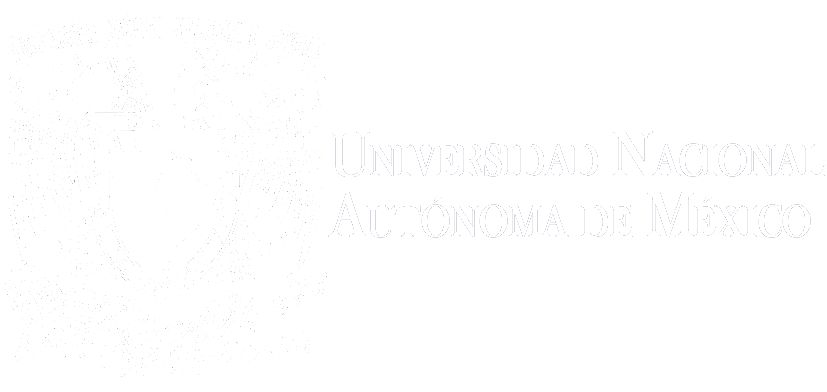



Codigo elaborado por Morales Ramírez Angel Francisco  [LinkedIn](https://www.linkedin.com/in/francisco-morales-actuario/)